Count results from BYO doped pool k-seq experiment, joined by `pandaSeq` with `joined first` and `absolute match in overlapped region`

 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/research/k-seq/notebooks/data-byodoped-pandaSeq.ipynb#Load-count-file-data-from-SeqTable" data-toc-modified-id="Load-count-file-data-from-SeqTable-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load count file data from <code>SeqTable</code></a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/research/k-seq/notebooks/data-byodoped-pandaSeq.ipynb#Sample-overview-characterization" data-toc-modified-id="Sample-overview-characterization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Sample overview characterization</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/research/k-seq/notebooks/data-byodoped-pandaSeq.ipynb#Pool-distribution" data-toc-modified-id="Pool-distribution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pool distribution</a></span></li><li><span><a href="http://localhost:8888/notebooks/research/k-seq/notebooks/data-byodoped-pandaSeq.ipynb#Variance-of-measurements" data-toc-modified-id="Variance-of-measurements-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Variance of measurements</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/research/k-seq/notebooks/data-byodoped-pandaSeq.ipynb#Variance-of-absolute-amount-vs.-mean-counts-in-triplicates" data-toc-modified-id="Variance-of-absolute-amount-vs.-mean-counts-in-triplicates-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Variance of absolute amount vs. mean counts in triplicates</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/research/k-seq/notebooks/data-byodoped-pandaSeq.ipynb#NOTE:-need-to-think-about-the-main-message-in-this-section" data-toc-modified-id="NOTE:-need-to-think-about-the-main-message-in-this-section-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>NOTE: need to think about the main message in this section</a></span></li></ul></li></ul></li><li><span><a href="http://localhost:8888/notebooks/research/k-seq/notebooks/data-byodoped-pandaSeq.ipynb#Compare-to-pool-design" data-toc-modified-id="Compare-to-pool-design-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare to pool design</a></span></li></ul></div>

In [4]:
from yuning_util.dev_mode import DevMode
pkg_dev = DevMode(pkg='k-seq')
pkg_dev.on()

from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.dpi"] = 300
plt.style.use('seaborn')

from k_seq.data import count_file, seq_table, seq_table_vis, transform, grouper
from k_seq.utility import func_tools
reload(func_tools)
reload(seq_table_vis)
reload(seq_table)
reload(transform)
reload(grouper)

<module 'k_seq.data.grouper' from '/home/yuning/research/k-seq/src/k_seq/data/grouper.py'>

# Load count file data from `SeqTable`
* by default, it loads from a pickled dataset object, it is optional to recalculate it from count files

In [2]:
byo_doped = seq_table.SeqTable.load_dataset(dataset='byo-doped')

Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo-doped-pandaSeq.pkl
Imported!


In [14]:
byo_doped.sample_overview()

,name,sample type,x value,unique seqs,total counts,"dna amount (from spike-in, ng)",spike-in rad,spike-in pct,"dna amount (from total dna, ng)"
A1,A1,reacted,0.001250,325072,12004474,126.887128,2,0.015762,123.000005
A2,A2,reacted,0.001250,286894,11752226,158.156660,2,0.012646,128.000000
A3,A3,reacted,0.001250,447832,24822840,258.018928,2,0.007751,182.000016
B1,B1,reacted,0.000250,154859,11116634,143.038086,2,0.013982,115.000002
B2,B2,reacted,0.000250,161226,12552203,138.647819,2,0.014425,111.499998
B3,B3,reacted,0.000250,142257,11352810,133.840386,2,0.014943,97.999996
C1,C1,reacted,0.000050,245902,8935891,73.335776,2,0.013636,50.000000
C2,C2,reacted,0.000050,160632,9571053,48.577368,2,0.020586,34.500000
C3,C3,reacted,0.000050,171873,10536759,60.456021,2,0.016541,46.000001
D1,D1,reacted,0.000010,393249,12523217,16.260751,2,0.012300,10.788097


## Sample overview characterization

In [10]:
marker_map = {'0': 'o', '1': 'o', '2': '^', '3': 's'}
color_map = {'R': '#AEAEAE', 'A': '#2C73B4', 'B': '#70C7C7',
             'C': '#1C7725', 'D':'#F39730', 'E': '#B2112A'}
from k_seq.utility.plot_tools import sample_rename_byo_doped

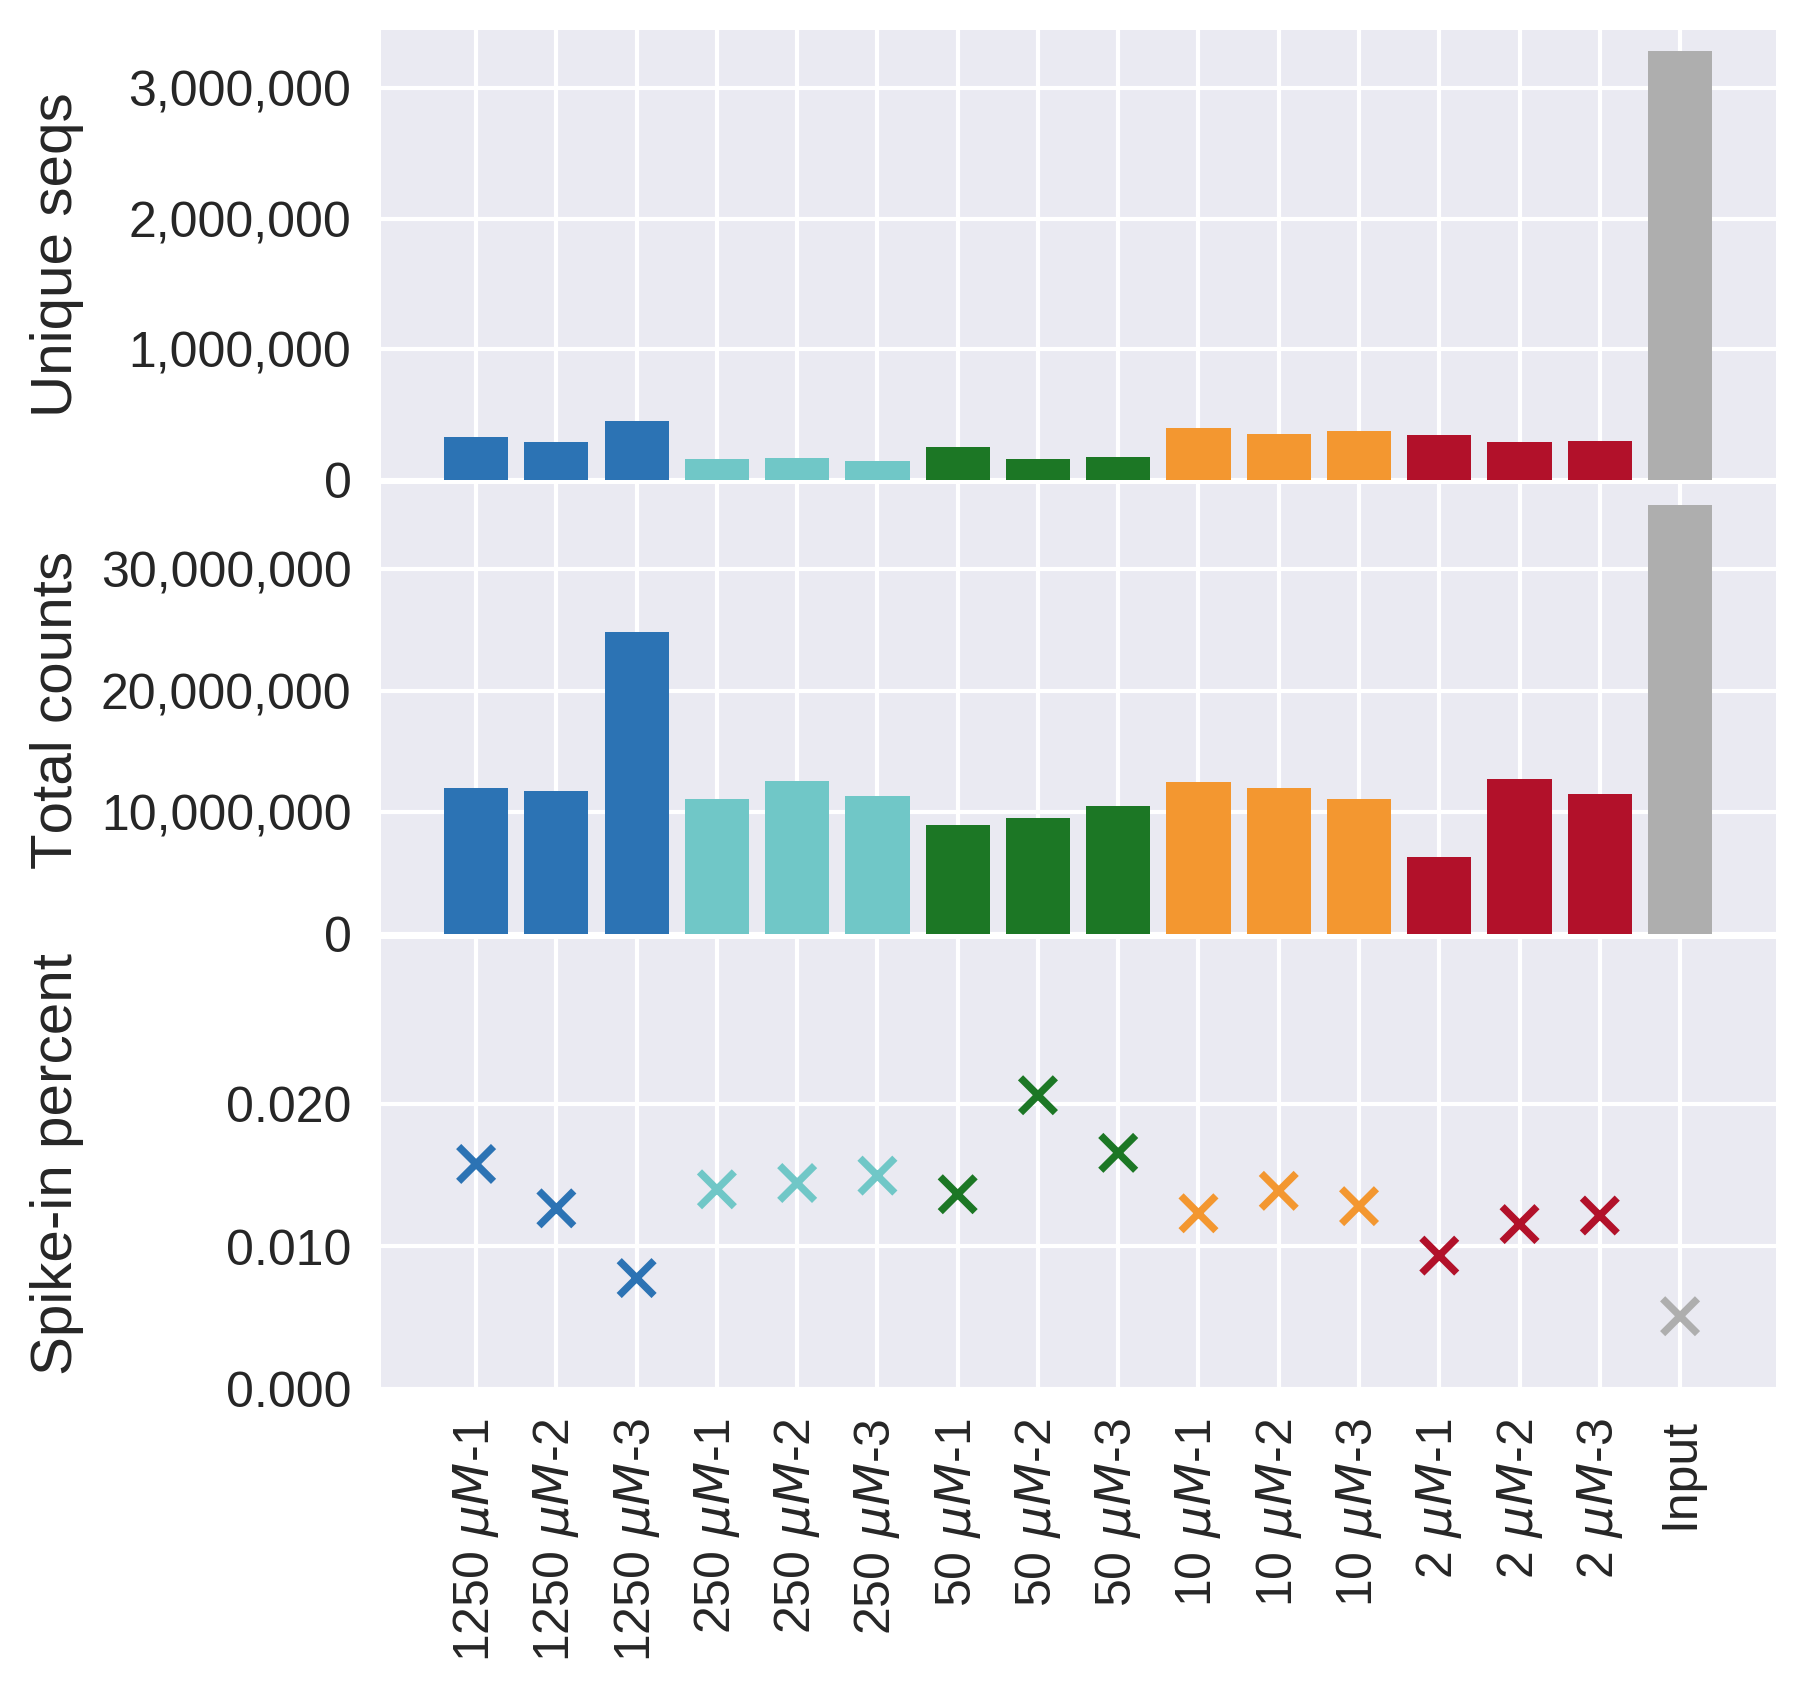

In [8]:
seq_table_vis.sample_overview_plots(
    seq_table=byo_doped,
    color_map={sample: color_map[sample[0]] for sample in byo_doped.sample_list},
    label_mapper=sample_rename_byo_doped,
    figsize=[6, 6]
)

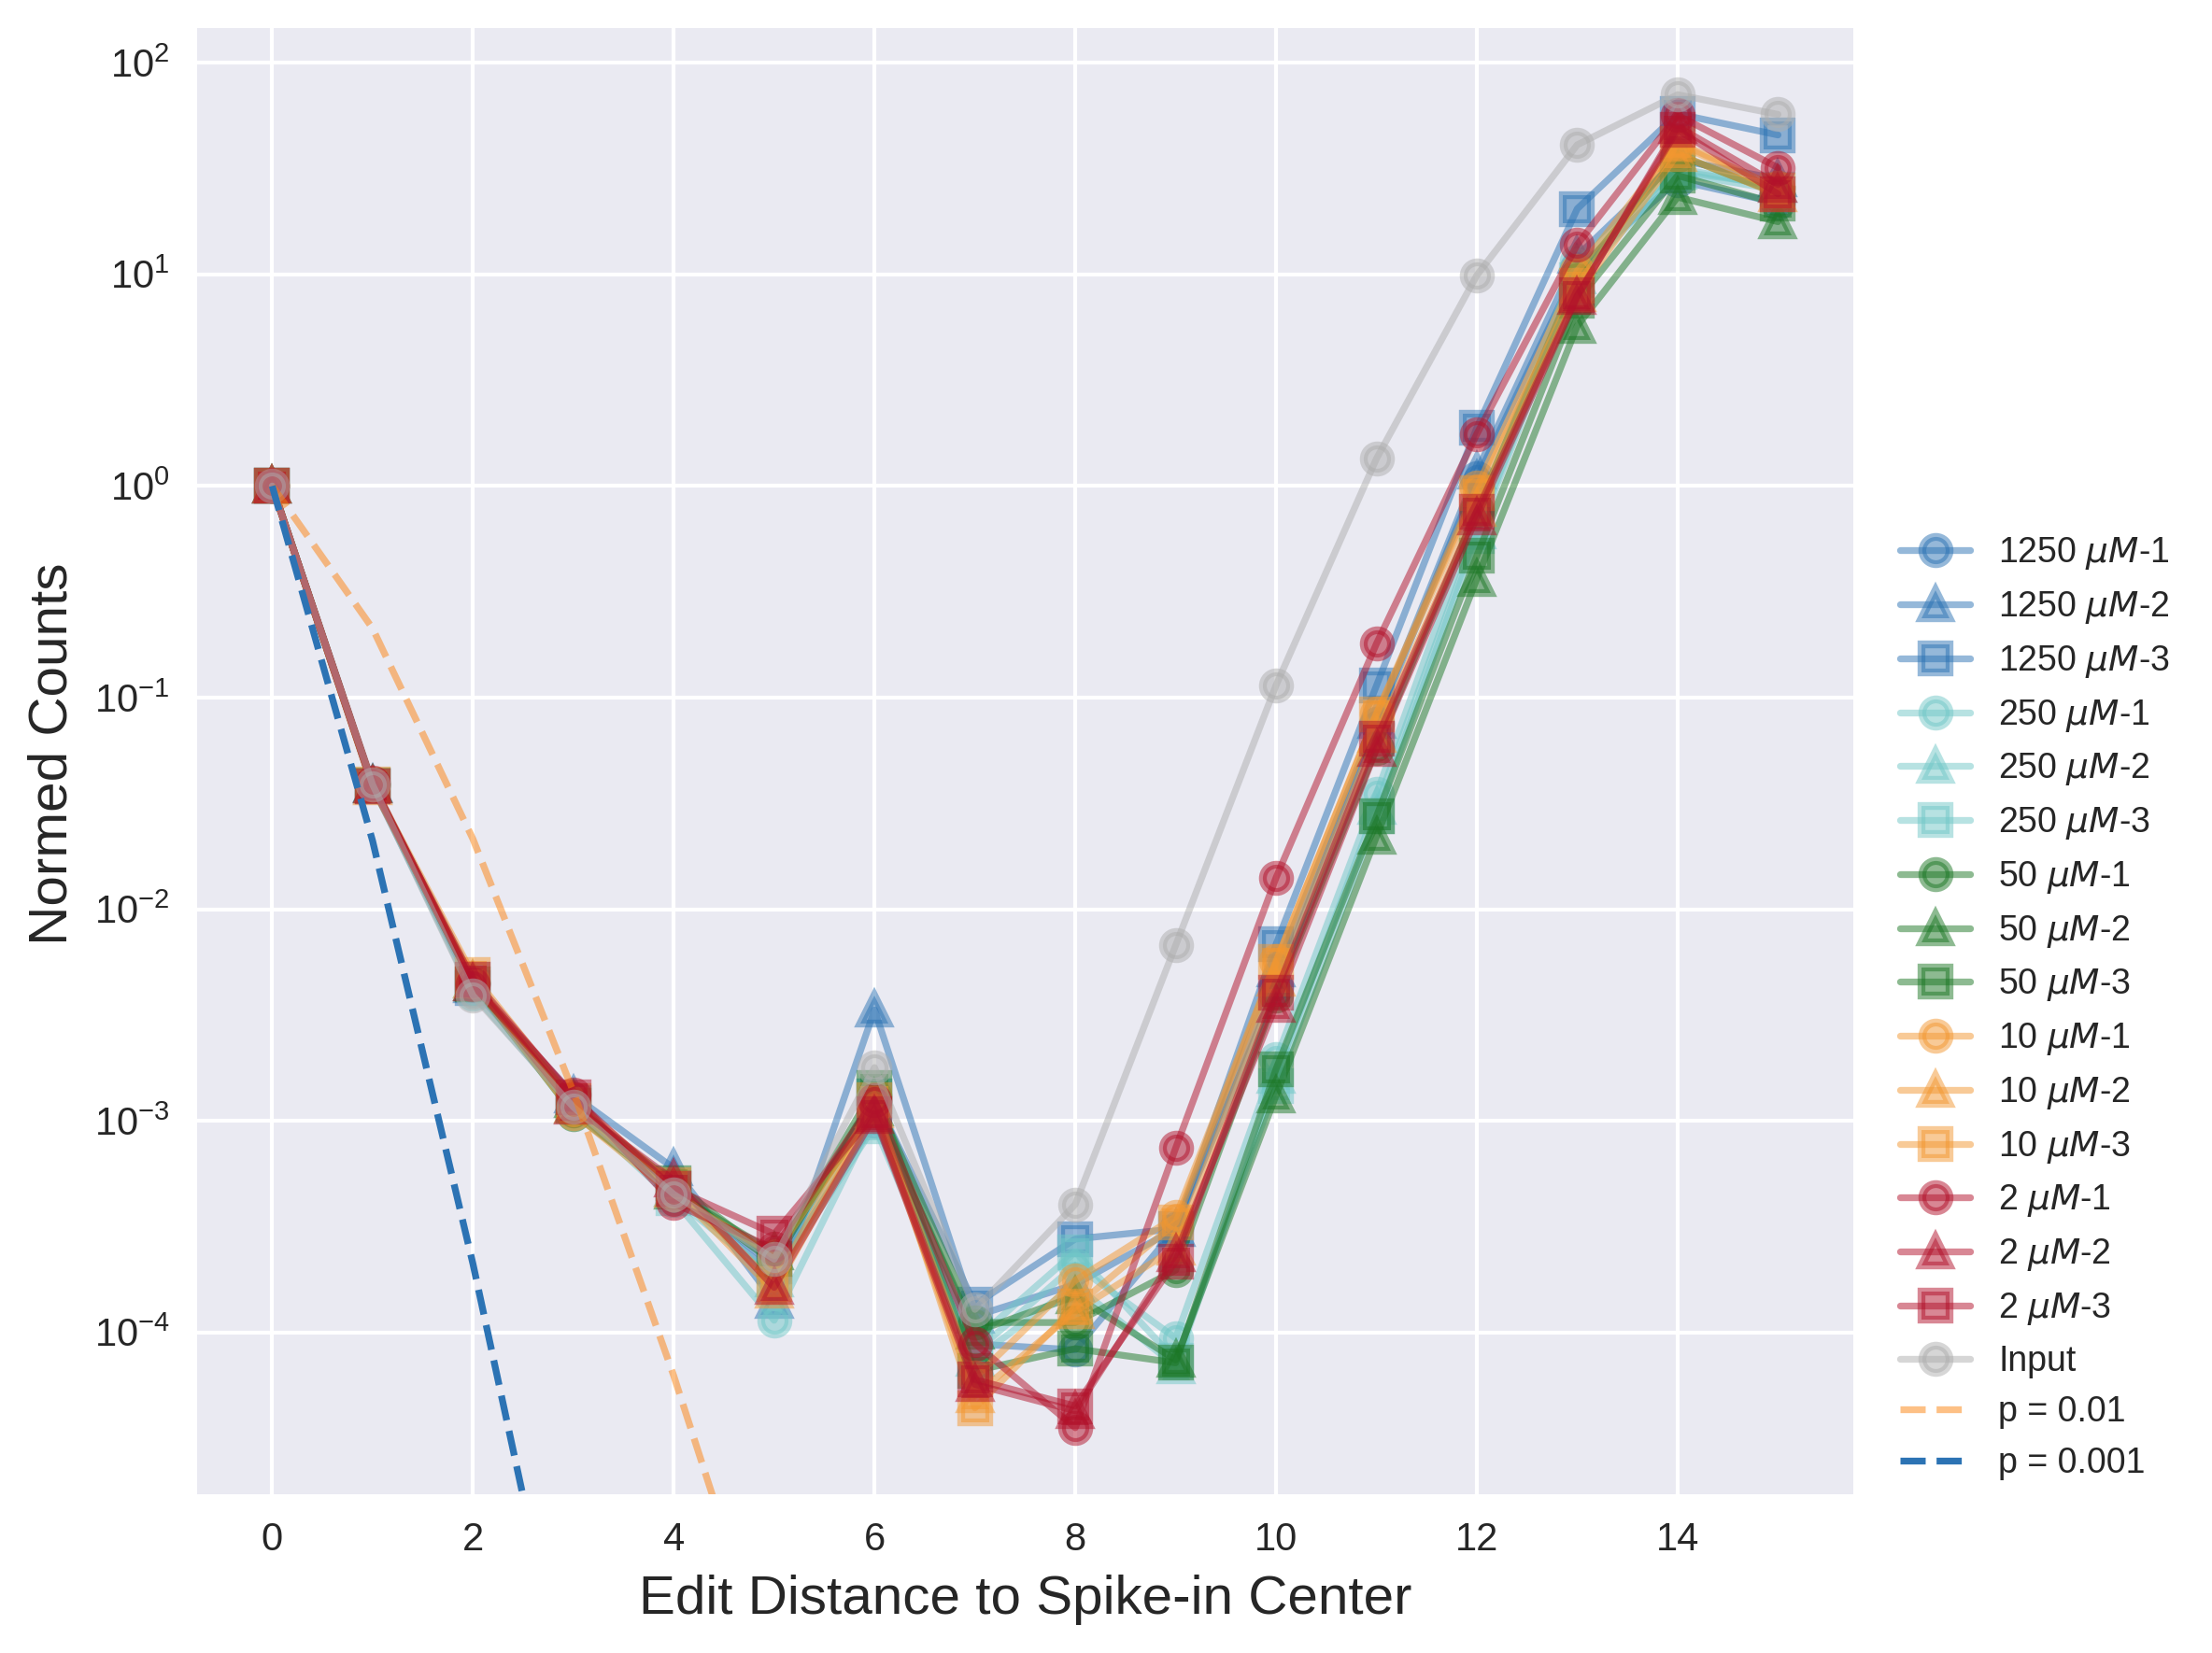

In [11]:
reload(transform)
transform.spike_in_peak_plot(
    spike_in=byo_doped.spike_in,
    sample_list=byo_doped.sample_list.values,
    marker_list=[marker_map[sample[-1]] for sample in byo_doped.sample_list.values],
    color_list=[color_map[sample[0]] for sample in byo_doped.sample_list.values],
    err_guild_lines=[1e-2, 1e-3],
    label_map=sample_rename_byo_doped,
    figsize=[8, 6],
    legend_col=1
)
plt.show()

Text(0, 0.5, 'Std. Dev. of DNA amount')

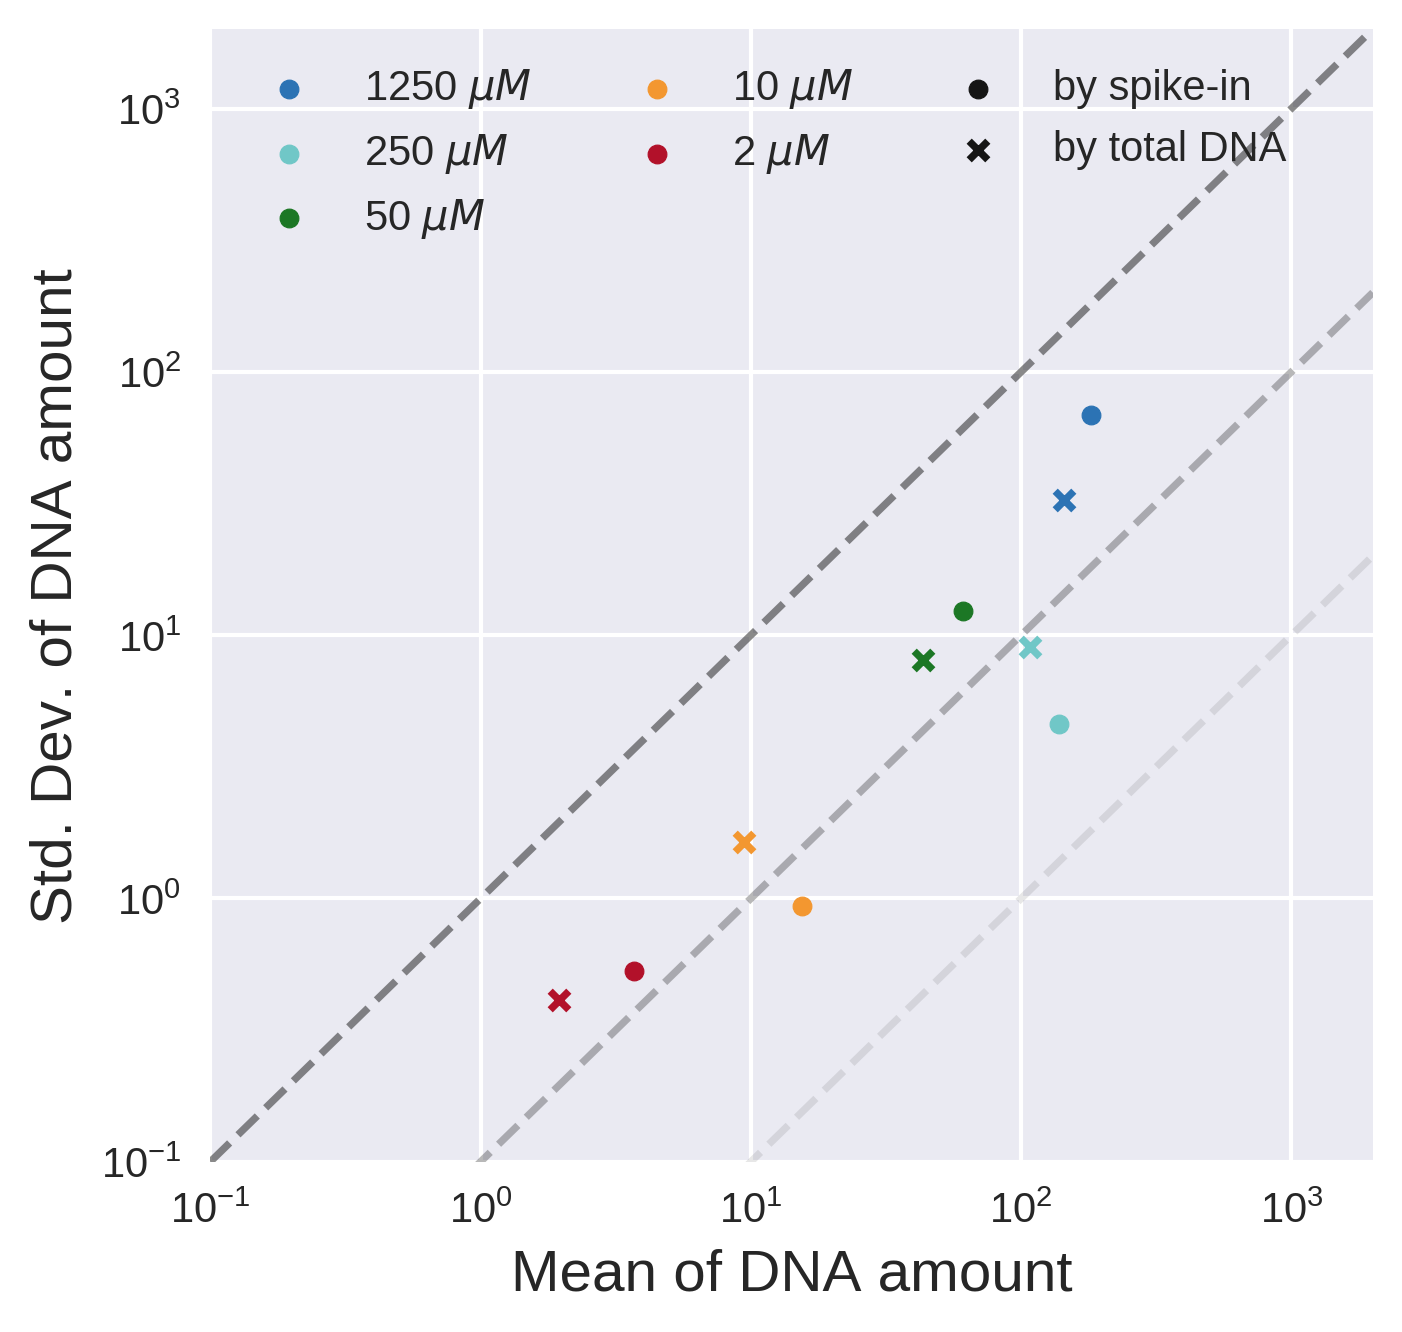

In [13]:
dna_amount = byo_doped.sample_overview()[['dna amount (from spike-in, ng)', 'dna amount (from total dna, ng)']]
label_map = {'A': '1250 $\mu M$', 'B': '250 $\mu M$', 'C': '50 $\mu M$', 'D': '10 $\mu M$', 'E': '2 $\mu M$',
             'R':None}

fig, ax = plt.subplots(1,1, figsize=(5, 5))
for byo, color in color_map.items():
    samples = [sample for sample in dna_amount.index if sample[0] == byo]
    ax.scatter(dna_amount.loc[samples, 'dna amount (from spike-in, ng)'].mean(),
               dna_amount.loc[samples, 'dna amount (from spike-in, ng)'].std(), marker='o', s=20, color=color, label=label_map[byo])
    ax.scatter(dna_amount.loc[samples, 'dna amount (from total dna, ng)'].mean(),
               dna_amount.loc[samples, 'dna amount (from total dna, ng)'].std(), marker='x', s=20, color=color)

ax.scatter([],[], marker='o', s=20, color='#151515', label='by spike-in')  
ax.scatter([],[], marker='x', s=20, color='#151515', label='by total DNA')  
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1, 2000])
ax.set_ylim([0.1, 2000])
ax.legend(loc='upper left', ncol=3)

xs = np.logspace(np.log10(0.1), np.log10(2000), 20)
ax.plot(xs, xs, '#151515', alpha=0.5, ls='--', zorder=1)
ax.plot(xs, xs * 0.1, '#151515', alpha=0.3, ls='--', zorder=1)
ax.plot(xs, xs * 0.01, '#151515', alpha=0.1, ls='--', zorder=1)
ax.set_xlabel('Mean of DNA amount', fontsize=14)
ax.set_ylabel('Std. Dev. of DNA amount', fontsize=14)

# Pool distribution

In [3]:
byo_doped.table_filtered

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
CTACTTCAAACAATCGGTCTG,1982202,2126445,4462180,2272990,2802263,2489170,1444732,1972577,2089579,1814277,1921108,1631505,736196,1824619,1467397,1383177
CCACACTTCAAGCAATCGGTC,1829130,1967544,4258279,1914628,2290732,2088238,1073942,1440882,1479599,1300644,1403969,1096641,505728,1277973,978130,1184455
ATTACCCTGGTCATCGAGTGA,1176139,1066368,2326251,1412078,1468178,1415013,2120000,1860438,2250280,3270198,2938993,3111478,1745140,4323335,4141402,1057445
AAGTTTGCTAATAGTCGCAAG,942917,811989,1825106,1016933,931936,859244,597423,555836,683796,712187,528682,490273,297229,401129,409464,1348922
GTACTTCAAACAATCGGTCTG,93571,89261,190112,95085,109320,96127,55457,72054,73539,68063,67091,52264,26048,57178,45148,81280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAAAAATCTAATGGTCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
AAAAAAGCTAATAGTCGCAAC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
AAAAAACTGTTCATCGAGTGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
AAAAAACTGGTCATCGAGTGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


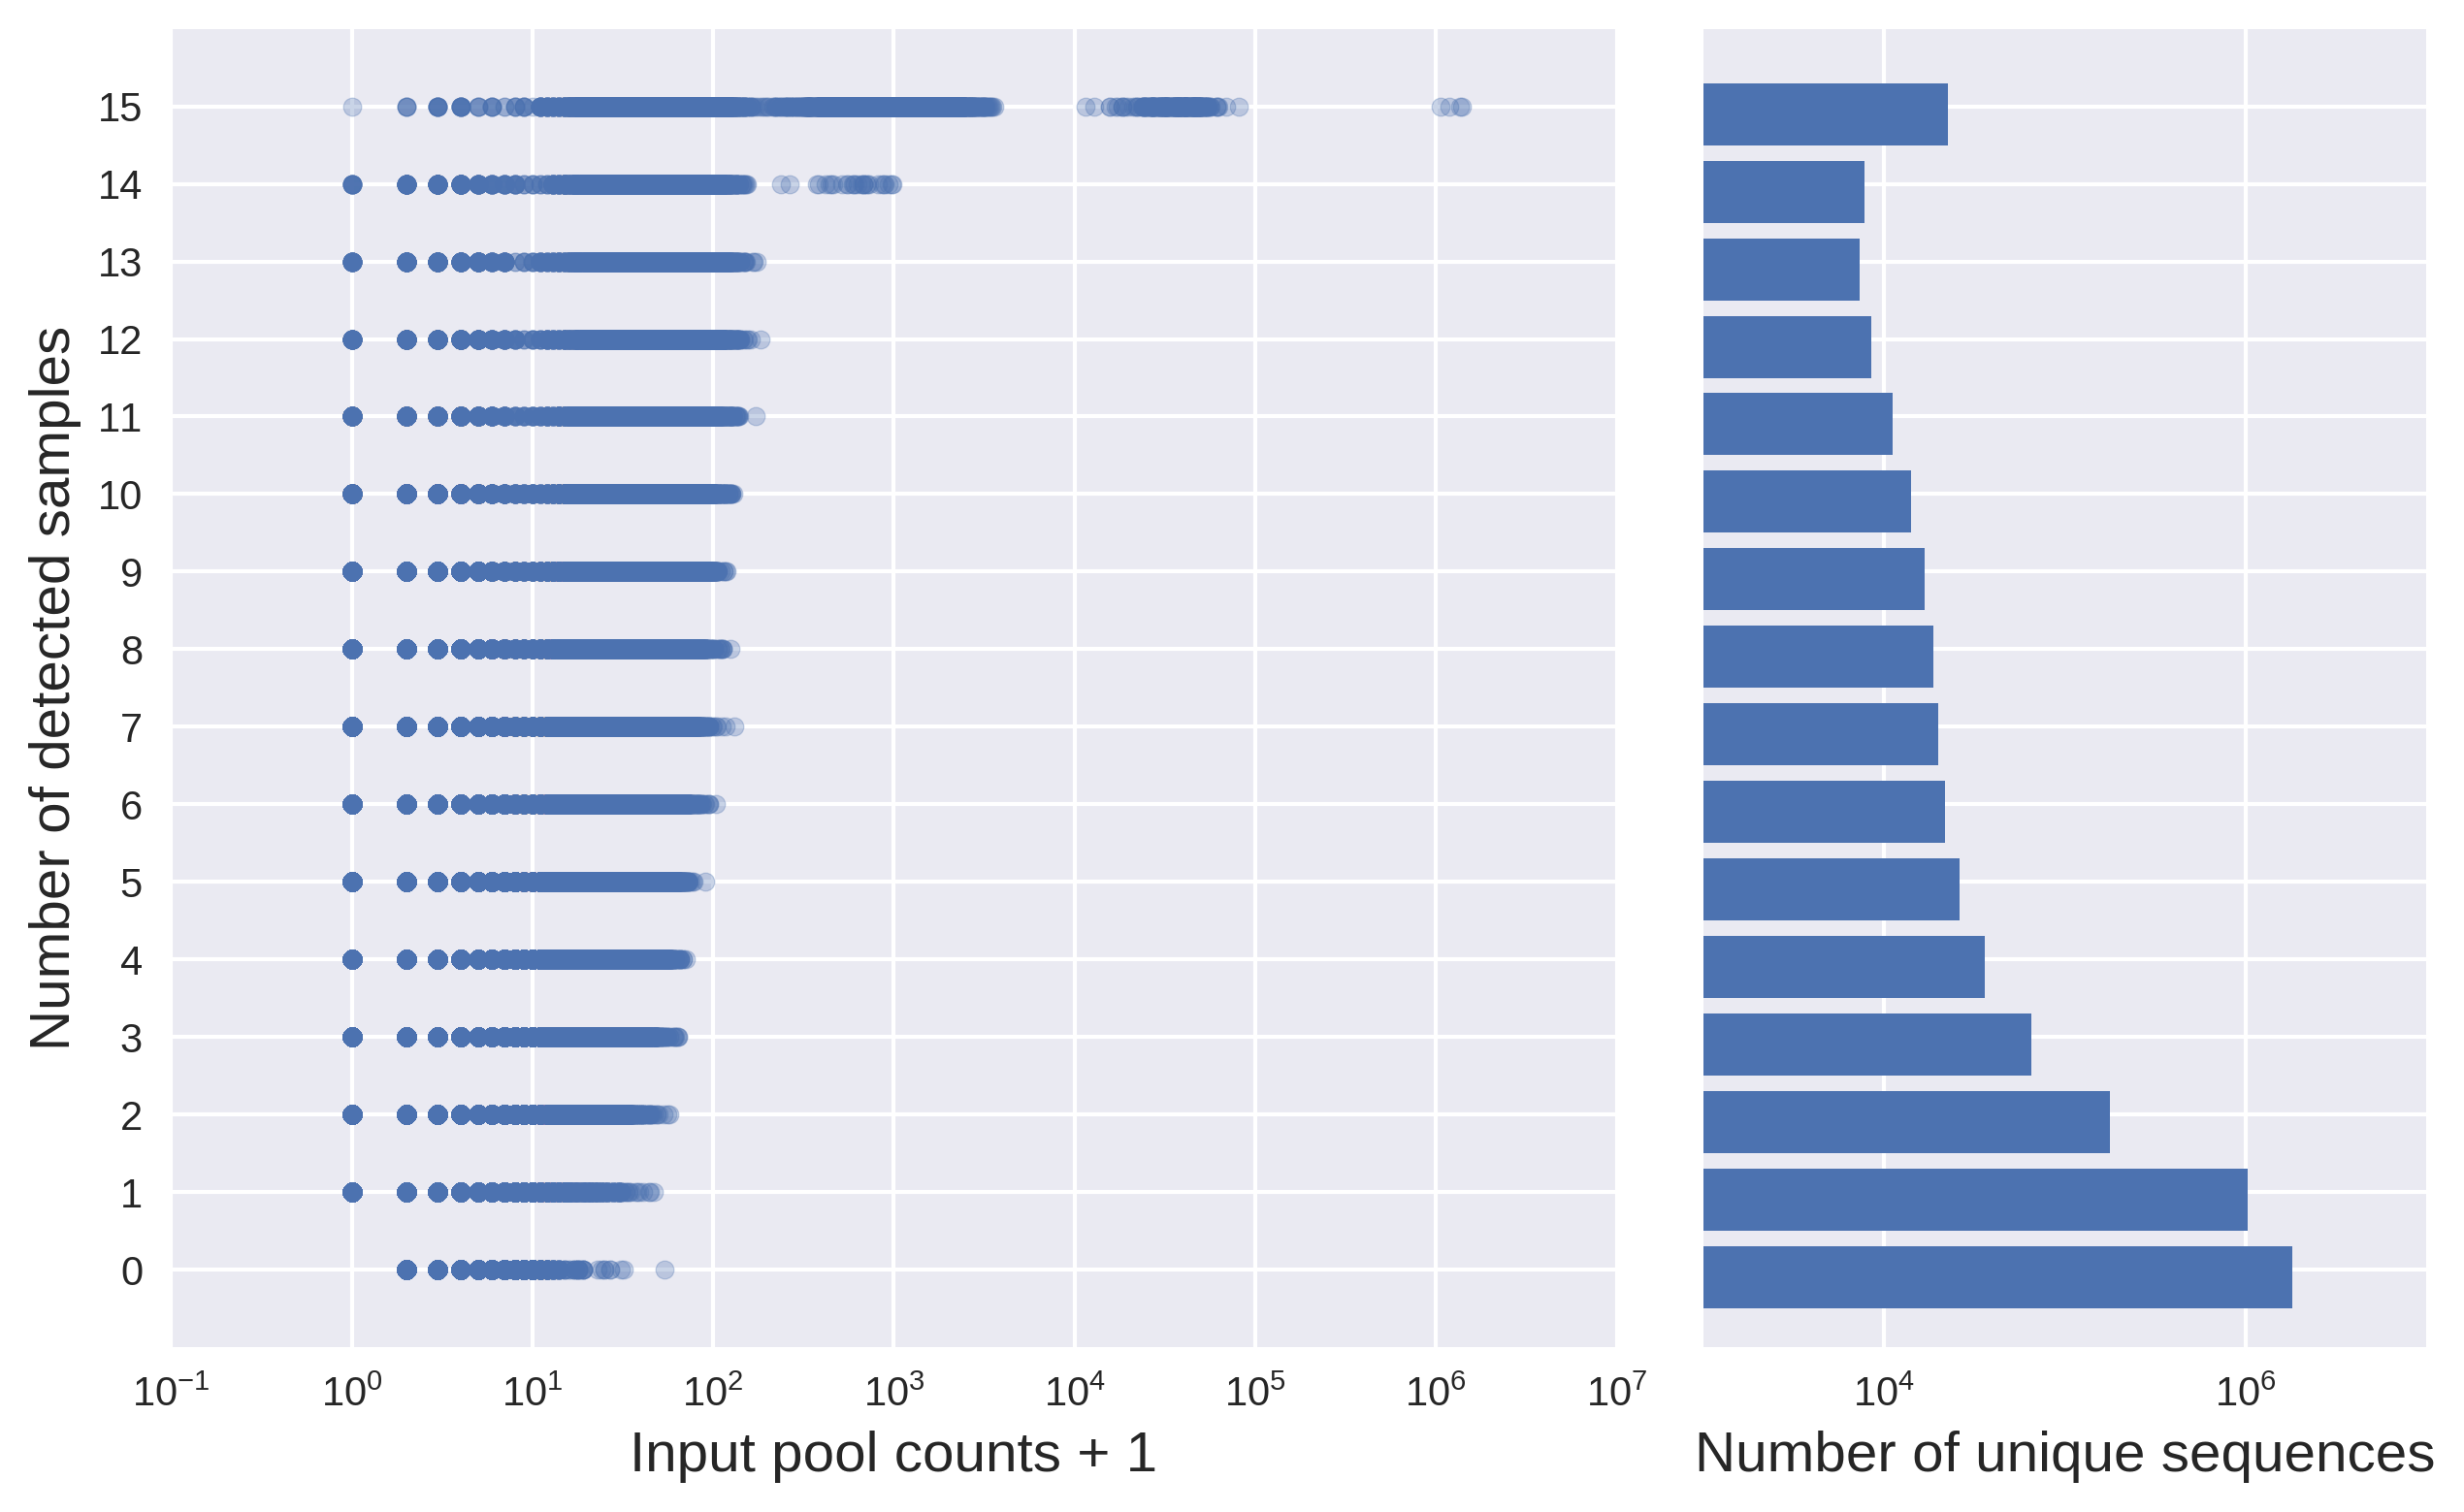

In [14]:
input_pool = byo_doped.table_filtered.loc[:, byo_doped.table_filtered.columns.isin(byo_doped.grouper.input)]
reacted_pool = byo_doped.table_filtered.loc[:, ~byo_doped.table_filtered.columns.isin(byo_doped.grouper.input)]

fig, axes = plt.subplots(1, 2, figsize=(10, 6),
                         gridspec_kw={'width_ratios': [2, 1]}, sharey=True)
fig.subplots_adjust(wspace=0.08, hspace=0.1)
occur = (reacted_pool > 0).sum(axis=1)

rel_abun = (input_pool.R0 + 1)

axes[0].scatter(rel_abun, occur, s=20, alpha=0.3)
axes[0].set_xlabel('Input pool counts + 1', fontsize=14)
axes[0].set_ylabel('Number of detected samples', fontsize=14)
axes[0].set_xscale('log')
axes[0].set_xlim([0.1, 1e7])
axes[0].set_ylim([-1, 16])
axes[0].set_yticks(np.arange(16))
axes[0].set_yticklabels(np.arange(16))

bins = np.linspace(-0.5, 16.5, 18)
axes[1].hist(occur, bins=bins, height=0.8, orientation='horizontal')
axes[1].set_xlabel('Number of unique sequences', fontsize=14)
axes[1].set_xscale('log')
axes[1].set_xlim([1e3, 1e7])

plt.show()

# Variance of measurements

## Variance of absolute amount vs. mean counts in triplicates

Some arguments:
  - counts (detected reads) are not repeated experiments and should not calculate variance
  - we assumed the absolute amount/reacted fraction for each seqs in triplicates should be a repeated results (in experimental sense), we can estimate based on that
  
  
  
### NOTE: need to think about the main message in this section

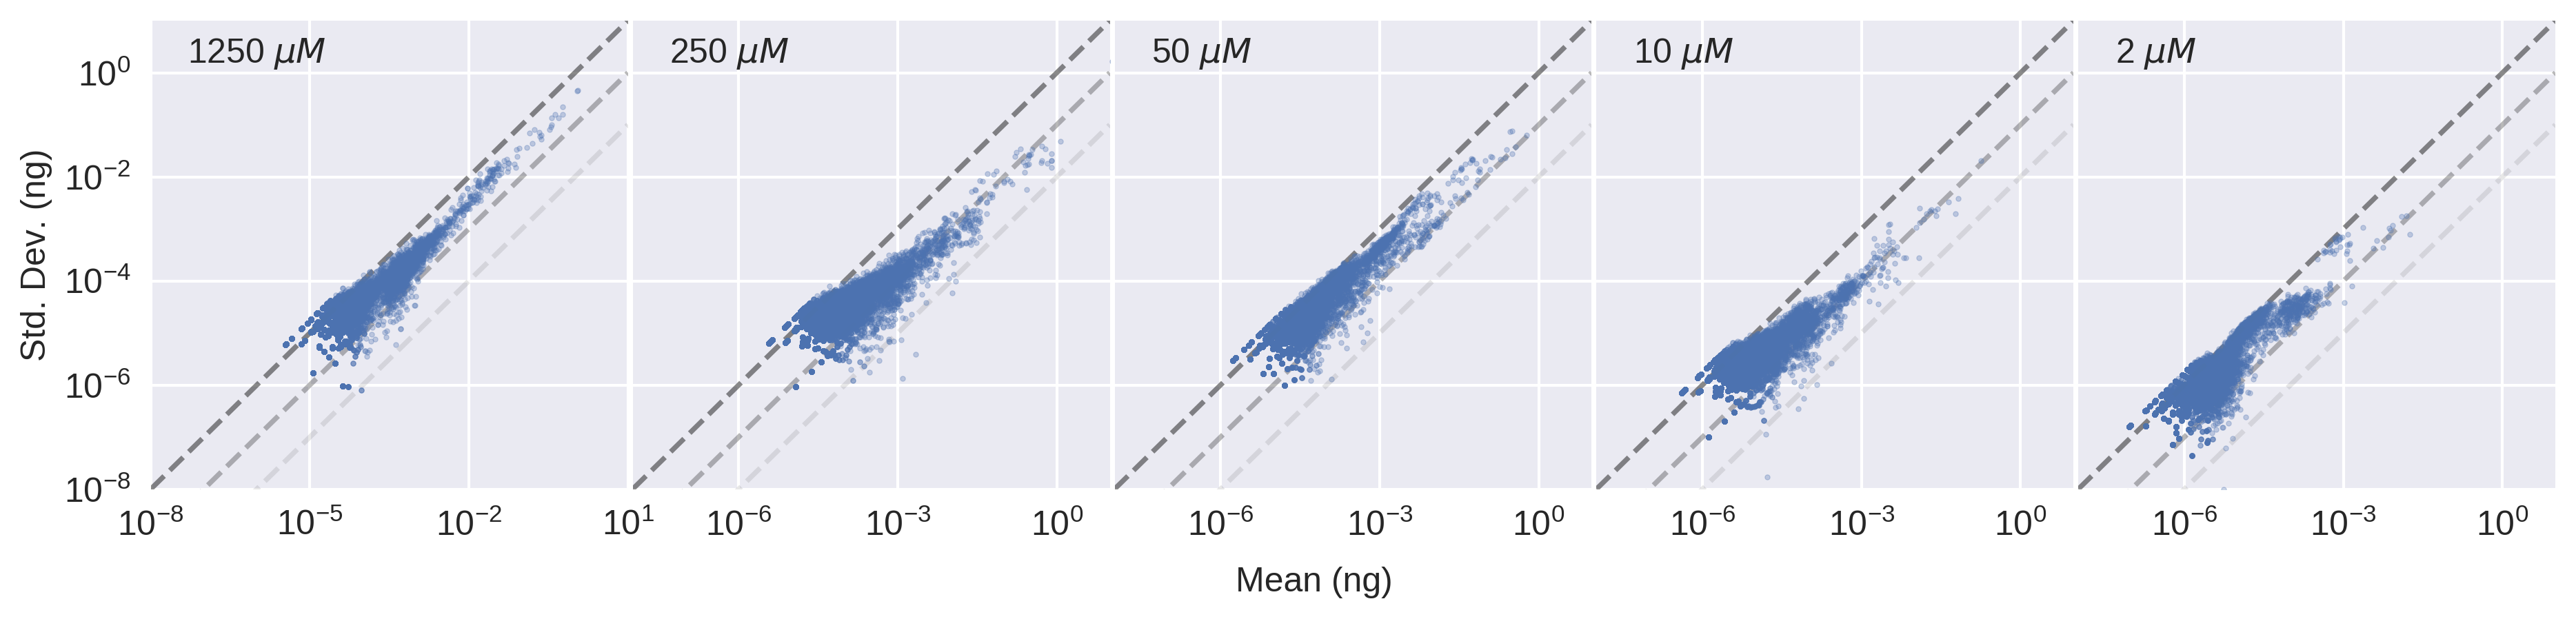

In [23]:
reload(seq_table_vis)
seq_table_vis.rep_variance_scatter(
    table=byo_doped.table_filtered_abs_amnt_spike_in, grouper=byo_doped.grouper.byo,
    subsample=int(1e5),
    xlim=(1e-8, 10), ylim=(1e-8, 10),
    xlog=True, ylog=True, group_title_pos=(5e-8, 5),
    xlabel='Mean (ng)', ylabel='Std. Dev. (ng)'
)

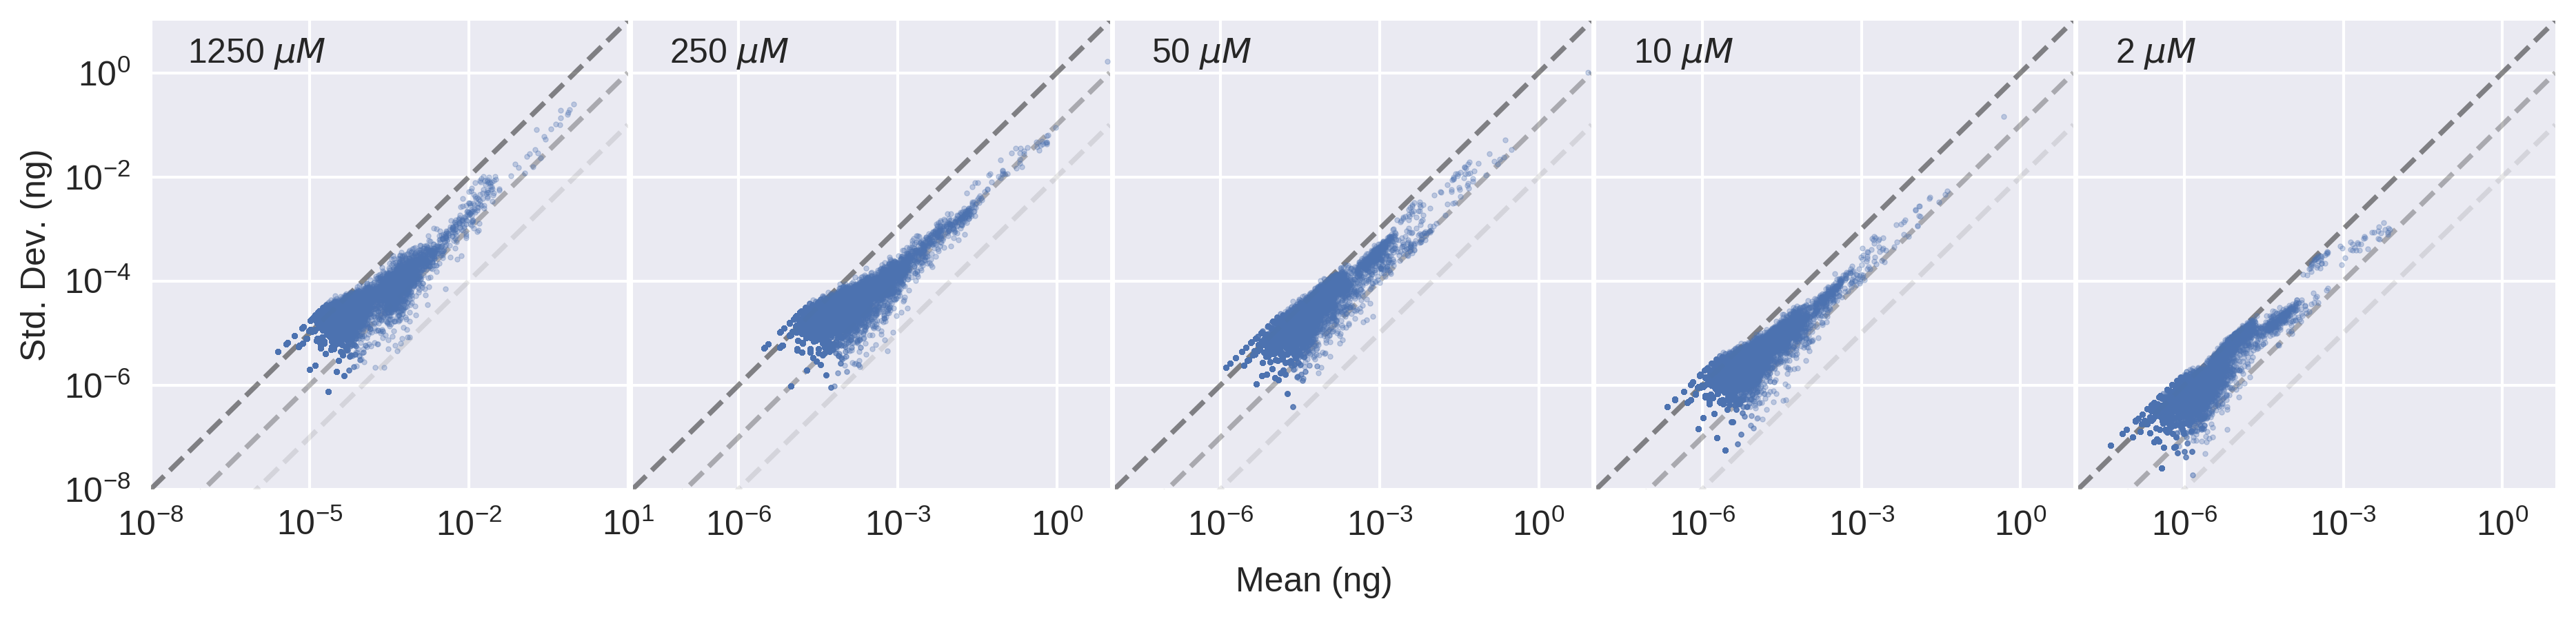

In [5]:
reload(seq_table_vis)
seq_table_vis.rep_variance_scatter(
    table=byo_doped.table_filtered_abs_amnt_total_dna, grouper=byo_doped.grouper.byo,
    subsample=int(1e5),
    xlim=(1e-8, 10), ylim=(1e-8, 10),
    xlog=True, ylog=True, group_title_pos=(5e-8, 5),
    xlabel='Mean (ng)', ylabel='Std. Dev. (ng)'
)

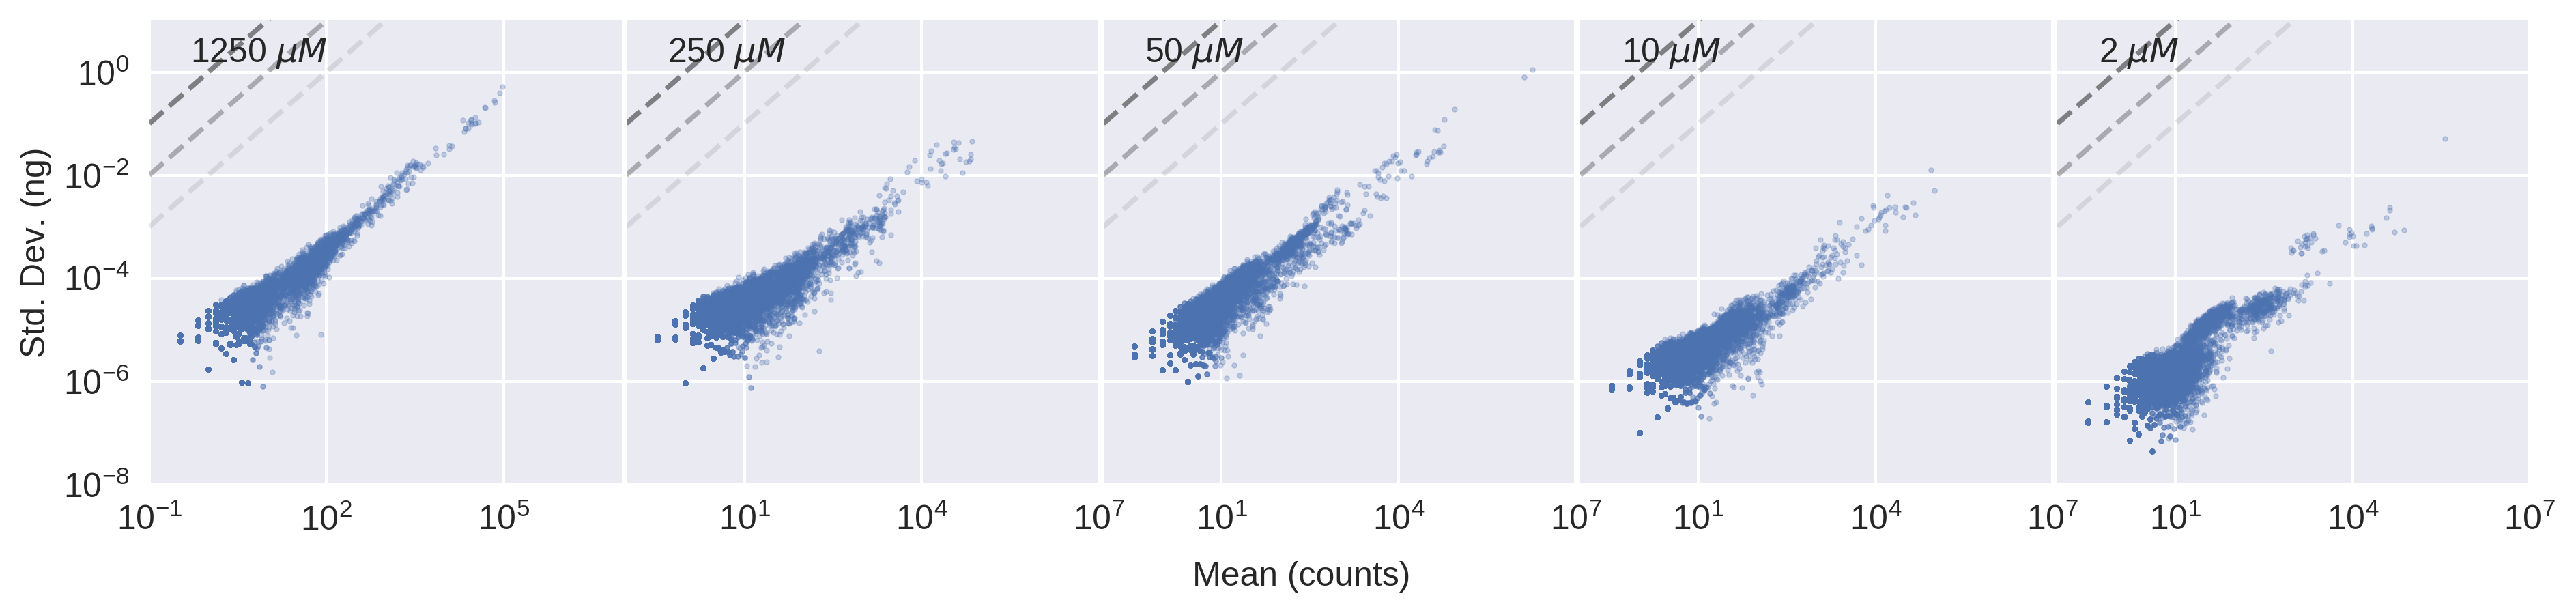

In [27]:
reload(seq_table_vis)
seq_table_vis.rep_variance_scatter(
    table=byo_doped.table_filtered_abs_amnt_spike_in, xaxis=byo_doped.table,
    grouper=byo_doped.grouper.byo,
    subsample=int(1e5),
    xlim=(0.1, 1e7), ylim=(1e-8, 10),
    xlog=True, ylog=True, group_title_pos=(0.5, 5),
    xlabel='Mean (counts)', ylabel='Std. Dev. (ng)')

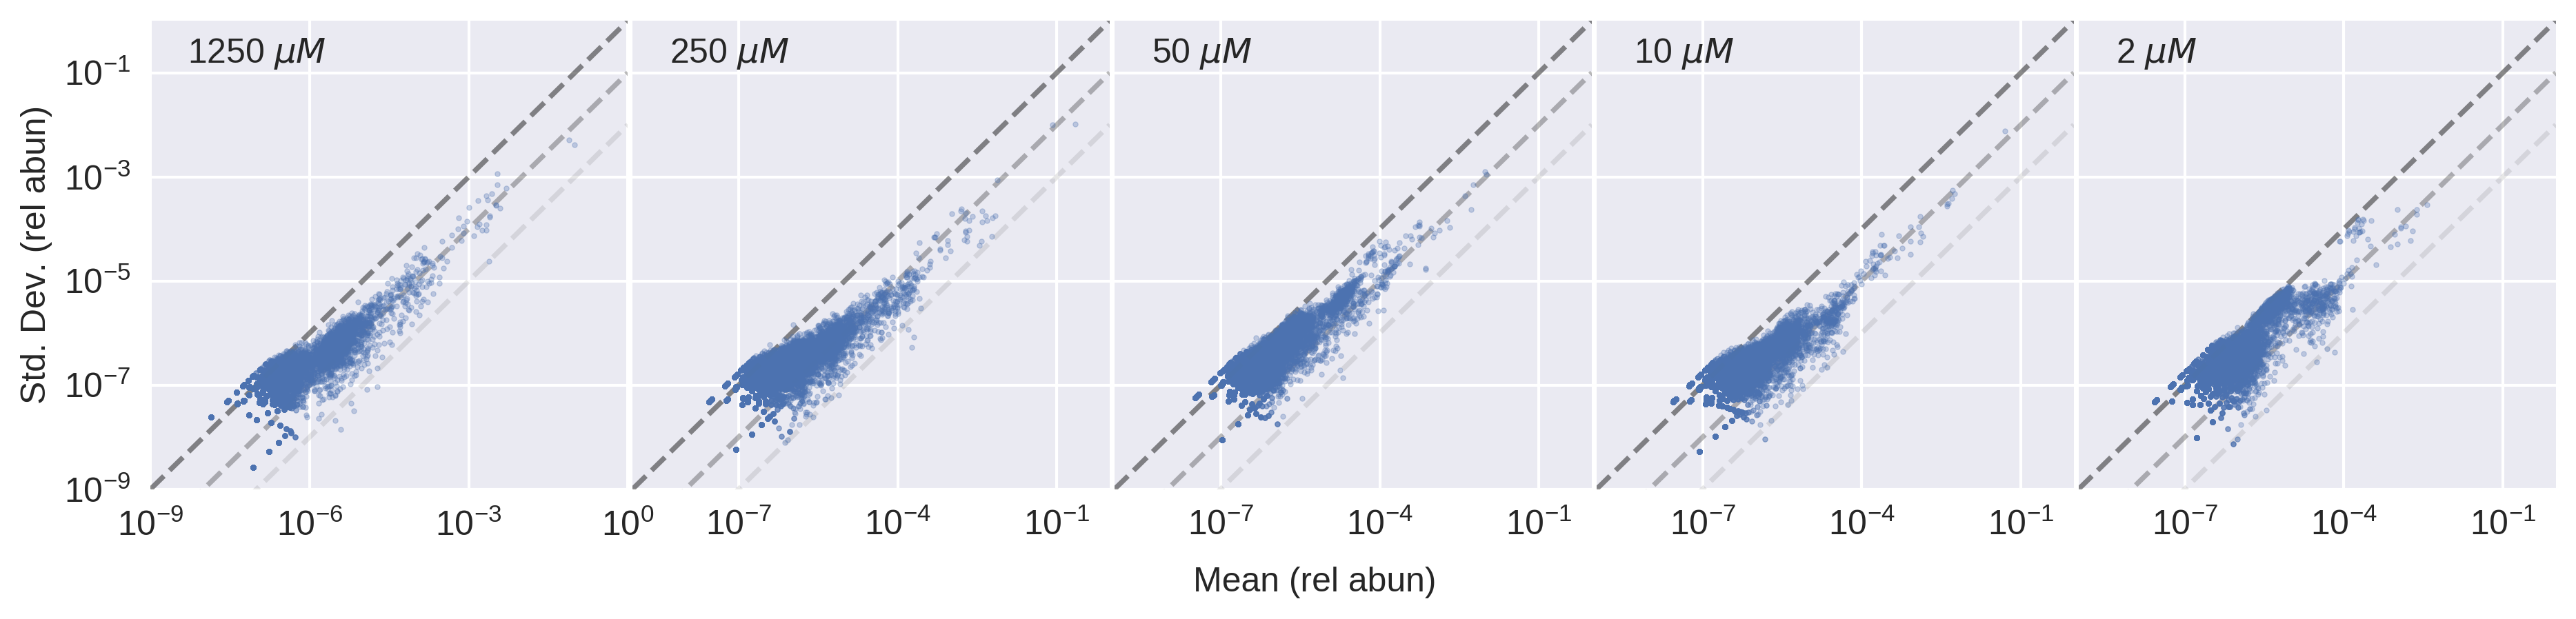

In [36]:
reload(seq_table_vis)
rel_abun_table = byo_doped.table_filtered
rel_abun_table = rel_abun_table / rel_abun_table.sum(axis=0)

byo_group = grouper.Group({1250:['A1', 'A2', 'A3'],
           250: ['B1', 'B2', 'B3'],
           50: ['C1', 'C2', 'C3'],
           10: ['D1', 'D2', 'D3'],
           2: ['E1', 'E2', 'E3']}, target=rel_abun_table
)

seq_table_vis.rep_variance_scatter(
    table=rel_abun_table,
    grouper=byo_group,
    subsample=int(1e5),
    xlim=(1e-9, 1), ylim=(1e-9, 1),
    xlog=True, ylog=True, group_title_pos=(5e-9, 0.5),
    xlabel='Mean (rel abun)', ylabel='Std. Dev. (rel abun)'
)

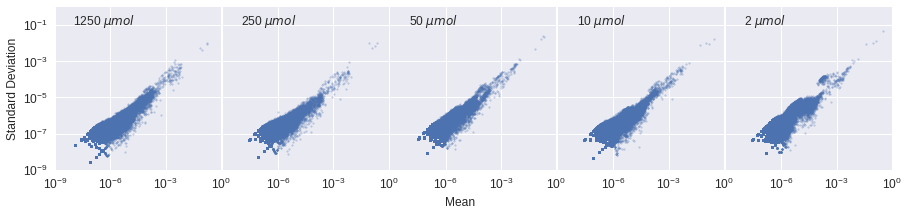

In [17]:

## Old code for plotting

table_gen = byo_table.grouper.byo.get_table(remove_zero=True)

fig, axes = plt.subplots(1, 5, figsize=[15, 3], sharey=True)
fig.subplots_adjust(hspace=0, wspace=0.01)

for ix, ((key, table), ax) in enumerate(zip(table_gen, axes)):
    rel_abun = table / table.sum(axis=0)
    ax.scatter(rel_abun.mean(axis=1), rel_abun.std(axis=1), s=3, alpha=0.3)
    ax.text(s=f'{key:d} $\mu mol$', x=1e-8, y=1e-1, fontsize=12)
    ax.set_xscale('log')
    ax.set_xlim([1e-9, 1])
    ax.set_yscale('log')
    ax.set_ylim([1e-9, 1])
    ax.tick_params(axis='both', labelsize=12)
    if ix > 0:
        xticks = [tick for tick in ax.get_xticks()][2:-1]
        ax.set_xticks(xticks)
    else:
        ax.set_ylabel('Standard Deviation', fontsize=12)
    
fig.text(s='Mean', x=0.5, y=0, ha='center', va='top', fontsize=12)
plt.show()

# Compare to pool design

In [12]:
def peak_abun_plot(peak, max_radius, rel_abun_table=None, sample_grouper=None, sample_plot_kwargs=None,
                   show_y_label=False, ax=None, save_fig_to=None):
    peak_abun_info, peak_uniq_seq = peak.peak_abun(max_radius=max_radius,
                                                   rel_abun_table=rel_abun_table)
    
    if sample_grouper is not None:
        peak_abun_info = pd.DataFrame.from_dict(
            {x_val: peak_abun_info[group].mean(axis=1)
             for x_val, group in sample_grouper.items()},
            orient='columns'
        )
        
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    if sample_plot_kwargs is None:
        from k_seq.utility.plot_tools import PlotPreset
        colors = PlotPreset.colors(num=len(peak_abun_info.columns))
        markers = PlotPreset.markers(num=len(peak_abun_info.columns), with_line=False)
        sample_plot_kwargs = {
            sample: {'color': color,
                     'marker': marker}
            for sample, color, marker in zip(peak_abun_info.columns, colors, markers)
        }
    loc = np.arange(0, max_radius + 1)
    
    sample_name_map = {
        1250: '1250 $\mu M$',
        250: '250 $\mu M$',
        50: '50 $\mu M$',
        10: '10 $\mu M$',
        2: '2 $\mu M$',
        0: 'Input',
    }
    for sample in peak_abun_info.columns:
        ax.plot(loc, peak_abun_info[sample], ls='-', markeredgewidth=2, **sample_plot_kwargs[sample],
                label=sample_name_map[sample])
    ax_2 = ax.twinx()
    ax_2.plot(loc, peak_uniq_seq, ls='--', marker='.', color='#151515')
    ax_2.grid(b=False, which='both', axis='both')
    ax_2.set_yscale('log')
    
    if show_y_label:
        ax.set_ylabel('Relative abundance', fontsize=14)
    else:
        ax.set_yticklabels([])
        ax_2.set_yticklabels([])
    ax.tick_params(labelsize=12)
    ax.text(s=peak.name, x=0, y=ax.get_ylim()[1] * 0.9, fontsize=14, color='#151515')
    
    if save_fig_to:
        fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)

In [13]:
from k_seq.data import landscape
reload(landscape)

pool_peaks = {
    'pk2': 'ATTACCCTGGTCATCGAGTGA',
    'pk1A': 'CTACTTCAAACAATCGGTCTG',
    'pk1B': 'CCACACTTCAAGCAATCGGTC',
    'pk3': 'AAGTTTGCTAATAGTCGCAAG'
}

pool_peaks = [landscape.Peaks(target=byo_doped, center_seq=seq, name=name, radius=5)
              for name, seq in pool_peaks.items()]
mega_peak = landscape.Peaks.from_peak_list(pool_peaks)

In [10]:
# peak_abun returns (peak abun, num unique sequences)
pool_peaks[0].peak_abun(max_radius=5)[0][['A1', 'A2', 'A3']]

,A1,A2,A3
0,0.097975,0.090738,0.093714
1,0.172950,0.156236,0.159490
2,0.200315,0.179978,0.182487
3,0.210562,0.188856,0.190840
4,0.214367,0.192190,0.193905
5,0.215587,0.193243,0.194859


/home/yuning/research/k-seq/src/k_seq/data/landscape.py:65: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return rel_abun_table.loc[seqs].sum(axis=0)


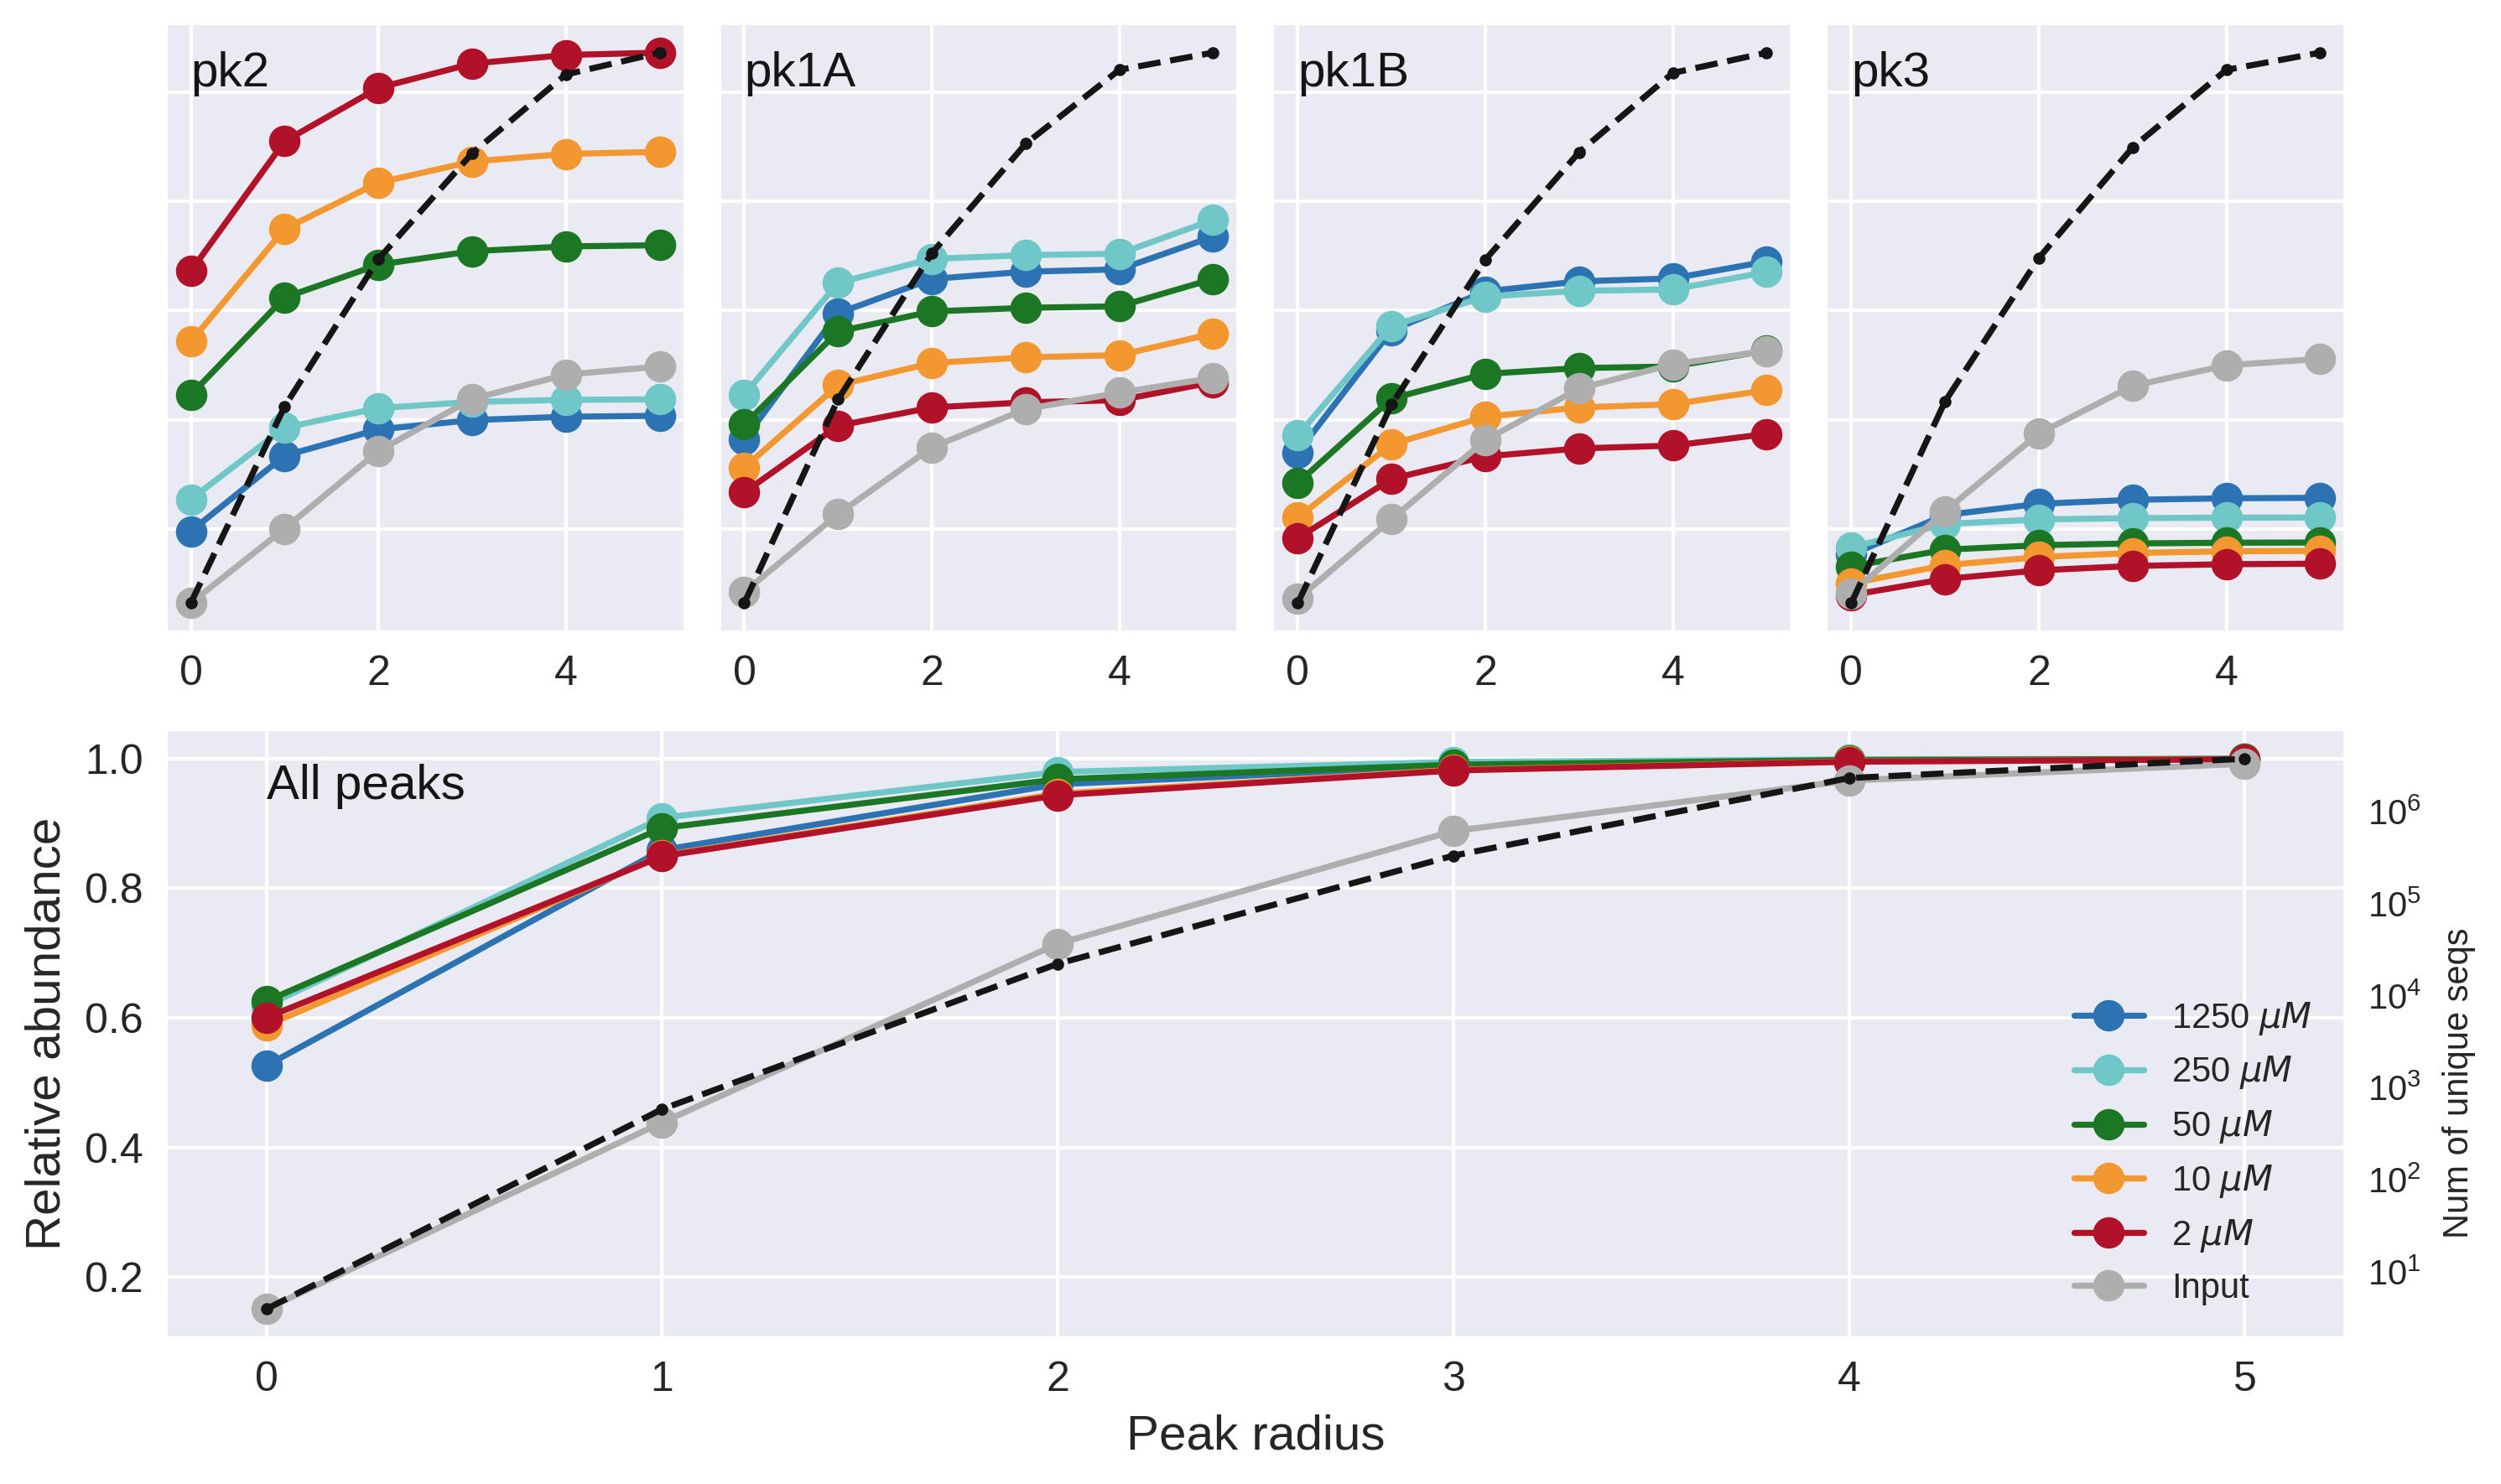

In [14]:
fig = plt.figure(figsize=[10, 6], constrained_layout=False)
gs = fig.add_gridspec(2, 4)

sample_grouper = {
    1250: ['A1', 'A2', 'A3'],
    250: ['B1', 'B2', 'B3'],
    50: ['C1', 'C2', 'C3'],
    10: ['D1', 'D2', 'D3'],
    2: ['E1', 'E2', 'E3'],
    0: ['R0']
}

axes = [fig.add_subplot(gs[0, 0])]
axes += [
    fig.add_subplot(gs[0, 1], sharey=axes[0]),
    fig.add_subplot(gs[0, 2], sharey=axes[0]),
    fig.add_subplot(gs[0, 3], sharey=axes[0]),
    fig.add_subplot(gs[1, :])
]


sample_plot_kwargs = {
    1250: {'color': '#2C73B4', 'marker': 'o', 'alpha': 1},
    250: {'color': '#70C7C7', 'marker': 'o', 'alpha': 1},
    50: {'color': '#1C7725', 'marker': 'o', 'alpha': 1},
    10: {'color': '#F39730', 'marker': 'o', 'alpha': 1},
    2: {'color': '#B2112A', 'marker': 'o', 'alpha': 1},
    0: {'color': '#AEAEAE', 'marker': 'o', 'alpha': 1},
}
        
peak_list = pool_peaks + [landscape.Peaks.from_peak_list(pool_peaks)]
peak_list[-1].name = 'All peaks'

for peak, ax in zip(peak_list, axes):
    peak_abun_plot(peak=peak, max_radius=5, sample_grouper=sample_grouper,
                   sample_plot_kwargs=sample_plot_kwargs, show_y_label=True if ax in [axes[-1]] else False,
                   rel_abun_table=byo_doped.table_filtered/byo_doped.table_filtered.sum(axis=0), ax=ax)
axes[0].set_yticklabels([])
axes[-1].legend(loc='lower right')
axes[-1].text(s='Num of unique seqs', x=5.5, y=0.5, ha='left', va='center', rotation=90)
axes[-1].set_xlabel('Peak radius', fontsize=14)

plt.tight_layout()

plt.show()